In [1]:
import numpy as np
import os
import pickle

from openmm import unit
from pymbar import timeseries

from tqdm import tqdm_notebook
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as ticker


In [6]:
def plot(value_data, ci_data, mutation_labels, save_path=None):
    """
    Generate heatmap for correlation between du/dlambda and degrees of freedom
    Adapted from mixing plots in Yank: https://github.com/choderalab/yank/blob/master/Yank/reports/notebook.py#L319

    Parameters
    ----------
    value_data : [n, 6] np.ndarray
        The correlations for each of n mutations
        The second dimension represents each of the 5 categories of degrees of freedrom plus the du/dlambda g(t)
    ci_data : [n, 5] np.ndarray
        95% confidence intervals for the correlations for each of n mutations
        The second dimension represents the 5 categories of degrees of freedom
    mutation_labels : list of str
        name for each mutation (format: {single letter amino acid for WT}-{residue id}-{single letter aminon acid for mutant})
    save_path : str
        filepath at which to save the figure
    """

    # Set figure size
    ncols = 6
    fig, axes = plt.subplots(nrows=1, ncols=ncols, sharey='col', figsize=(10, 12), squeeze=True)
    
    # Set font size
    plt.rc('font', size=14)

    # Set color map for correlation
    colors_correlation = ["white", "gray"] # first color is white, last is gray
    cmap_correlation = LinearSegmentedColormap.from_list("GrayWhite", colors_correlation)
    
   # Set color map for g_t
    colors_g_t = ["white", "#bc80bd"] # first color is white, last is purple
    cmap_g_t = LinearSegmentedColormap.from_list("PurpleWhite", colors_g_t)
    
    # Iterate over the columns
    du_dlambda = r"$\partial U / \partial \lambda$"
    col_labels = ["backbone\ntorsions", "sidechain\ntorsions", "intra interface\ncontacts", "inter interface\ncontacts", "neighboring\nwaters", f"{du_dlambda}\nstatistical\ninefficiency"]
    for col_index, col_label in enumerate(col_labels):
        
        # Plot one heatmap column
        column_values = np.reshape(value_data[:, col_index], (-1, 1))
        if col_index == ncols - 1: # use units of ns for statistical inefficiency column
            column_values = column_values / 10
        cmap = cmap_correlation if col_index != ncols - 1 else cmap_g_t
        vmin = 0 if col_index != ncols - 1 else 0.1
        vmax = 1 if col_index != ncols - 1 else max(column_values)
        output_image = axes[col_index].imshow(np.absolute(column_values), aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)
            
        # Label values
        for (j, i), value in np.ndenumerate(column_values):
            value_rounded = round(value, 2)
            if col_index != ncols - 1: # do not add cis to g(t) column
                column_ci = ci_data[j, col_index]
                label = f"${{{value_rounded}}}_{{{round(column_ci[0], 2)}}}^{{{round(column_ci[1], 2)}}}$"
            else:
                label = f"{value_rounded}"
            axes[col_index].text(i, j, label, ha='center', va='center', fontsize=12)
        
        # Label each column and remove x ticks
        axes[col_index].set_xlabel(col_label, fontsize=14, rotation=45, ha='center',  ma='left')
        axes[col_index].xaxis.set_major_locator(ticker.NullLocator())
        
        # Add color bars
        # fig.add_axes() adds the colorbar axes
        # they're bounded by [x0, y0, x_width, y_width]
        # From https://stackoverflow.com/questions/46040631/two-colorbars-on-image-grid-in-matplotlib
        bbox_ax = axes[0].get_position()
        if col_index == ncols - 2:
            cbar_correlation_ax = fig.add_axes([1.01, bbox_ax.y0 + 0.05, 0.02, bbox_ax.y1 - bbox_ax.y0 - 0.15])
            cbar_correlation = plt.colorbar(output_image, cax=cbar_correlation_ax, label='|PCC|')
        
        elif col_index == ncols - 1:
            cbar_g_t_ax = fig.add_axes([1.14, bbox_ax.y0 + 0.05, 0.02, bbox_ax.y1 - bbox_ax.y0 - 0.15])
            cbar_g_t = plt.colorbar(output_image, cax=cbar_g_t_ax, label=f'{du_dlambda} statistical inefficiency (ns)')
            
            # Set ticks.
            nticks = 6
            ticks = np.linspace(vmin, vmax, nticks)
            cbar_g_t.set_ticks(ticks)
        
    # Label x and y axes   
    fig.supxlabel('Degree of freedom category', x=0.55)
    fig.supylabel('Mutation', y=0.57)
    
    # Label each row
    y_positions = np.arange(0, len(mutation_labels), 1)
    axes[0].set_yticks(y_positions, mutation_labels, fontsize=14)
    for col in range(1, ncols):
        axes[col].yaxis.set_major_locator(ticker.NullLocator())
    
    # Set title
    fig.suptitle(f"Correlation of {du_dlambda} vs degree of freedom\nfor each mutation", x=0.57)

    # Ensure x-axis labels are not cut off
    plt.tight_layout()
    
    # Remove space between subplots
    plt.subplots_adjust(wspace=0.05, hspace=0.05)

    # Save plot as pdf
    if save_path:
        plt.savefig(save_path, dpi=500, bbox_inches='tight')
        plt.show()
    else:
        plt.show()


## Plot

In [3]:
# No averaging
phase = 'complex'
mutation_labels = ["Y29F", "Y29A",  "W38F", "T42A", "W44F", "E76A", "E80A", 
                   "D35A", "D39A", "K27A", "R59A", "R83Q", "R87A", "H102A", 
                   "F29Y", "A29Y",  "F38W", "A42T", "F44W", "A76E", "A80E", 
                   "A35D", "A39D", "A27K", "A59R", "Q83R", "A87R", "A102H"]

all_data = {}
for sub_dir, mutation in tqdm_notebook(enumerate(mutation_labels)):
    print(f"sub_dir: {sub_dir}")
    
    if sub_dir == 4:
        main_dir = 45
        sub_dir = 11
        replicate = 0
        n_replicas = 24
        is_checkpoint_interval_10 = False

    elif sub_dir == 12:
        main_dir = 45
        sub_dir = 10
        replicate = 1
        n_replicas = 36
        is_checkpoint_interval_10 = True

    elif sub_dir == 17:
        main_dir = 45
        sub_dir = 9
        replicate = 1
        n_replicas = 24
        is_checkpoint_interval_10 = True

    else:
        main_dir = 47
        replicate = 1
        is_checkpoint_interval_10 = False
        n_replicas = 24 if sub_dir in [0, 1, 2, 3, 14, 15, 16, 18] else 36

    out_dir = f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir}/{sub_dir}/replicate_{replicate}/"
    
    with open(os.path.join(out_dir, f"correlation_data_replicas_all_with_cis_50ns.pickle"), "rb") as f:
        correlation_data = pickle.load(f) # First 5 elements are PCCs for each of the dof categories, latter 5 elements are the corresponding CIs
    
    # Compute statistical inefficiency of du/dlambda
    du_dlambda_all = []
    for replica in range(n_replicas):
        with open(os.path.join(out_dir, f"{sub_dir}_{phase}_du_dlambda_replica{replica}.npy"), "rb") as f:
            du_dlambda = np.load(f)
        if is_checkpoint_interval_10:
            du_dlambda = du_dlambda[::10]
        du_dlambda_all.append(du_dlambda[:501])   
    du_dlambda_all = [val * unit.kilojoules_per_mole.conversion_factor_to(unit.kilocalories_per_mole) for val in du_dlambda_all]
    g_t_avg = round(timeseries.statisticalInefficiencyMultiple(du_dlambda_all), 2)
    correlation_data.append(g_t_avg)
        
    all_data[mutation] = correlation_data


/scratch/lsftmp/18464815.tmpdir/ipykernel_34816/2391964974.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sub_dir, mutation in tqdm_notebook(enumerate(mutation_labels)):


0it [00:00, ?it/s]

sub_dir: 0
sub_dir: 1
sub_dir: 2
sub_dir: 3
sub_dir: 4
sub_dir: 5
sub_dir: 6
sub_dir: 7
sub_dir: 8
sub_dir: 9
sub_dir: 10
sub_dir: 11
sub_dir: 12
sub_dir: 13
sub_dir: 14
sub_dir: 15
sub_dir: 16
sub_dir: 17
sub_dir: 18
sub_dir: 19
sub_dir: 20
sub_dir: 21
sub_dir: 22
sub_dir: 23
sub_dir: 24
sub_dir: 25
sub_dir: 26
sub_dir: 27


In [4]:
# Sort the mutations by statistical inefficiency (highest to lowest)
all_data_sorted = {k: v for k, v in sorted(all_data.items(), key=lambda item: item[1][-1], reverse=True)}
value_data_sorted = np.array([np.array(v[:5] + [v[-1]]) for k, v in all_data_sorted.items()]) # convert dict to array of arrays
ci_data_sorted = np.array([np.array(v[5:10]) for k, v in all_data_sorted.items()]) # convert dict to array of arrays
mutation_labels_sorted = [k for k, v in all_data_sorted.items()]

/scratch/lsftmp/18464815.tmpdir/ipykernel_34816/2472590030.py:95: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


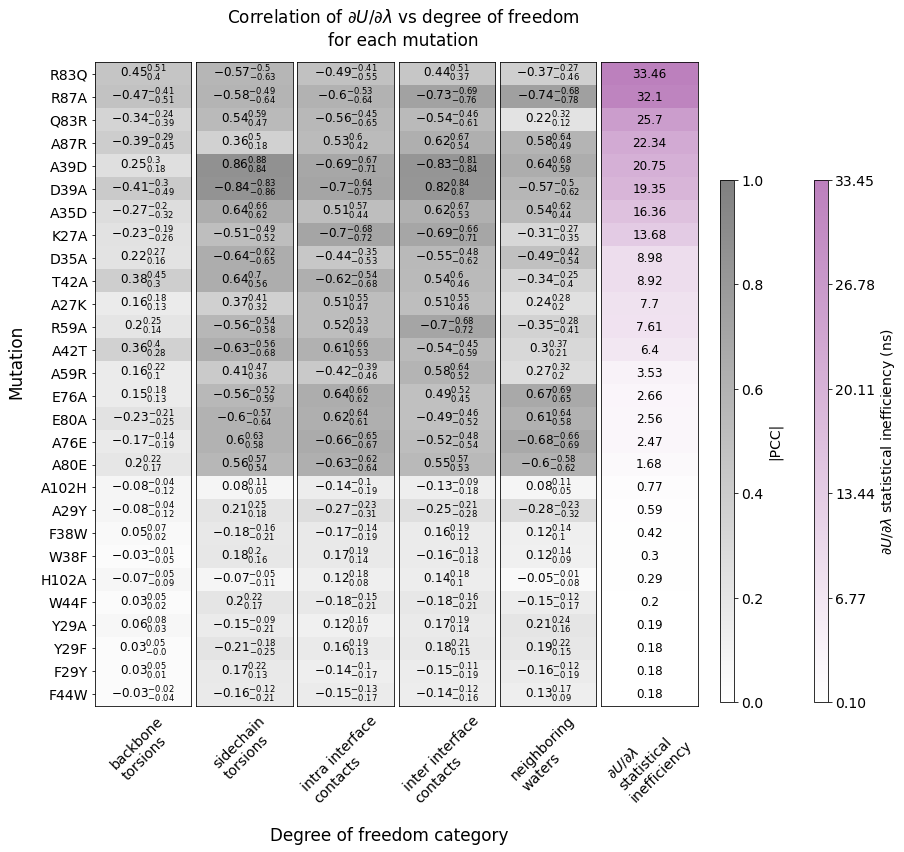

In [7]:
save_path = f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/correlations_heatmap_50ns.pdf"
plot(value_data_sorted, ci_data_sorted, mutation_labels_sorted, save_path=save_path)

In [12]:
# Note that we divide the statistical inefficiencies by 10 to get units of ns 
# because the samples are saved every 100 iterations and each iteration is 1 ps, 
# so the units of each sample are 100s of ps. Since 1000 ps is 1 ns, if we divide
# each statistical inefficiency by 10 (i.e. move the decimal place to the left by one digit), 
# we get units of ns.